<a href="https://colab.research.google.com/github/asyrofist/Extraction-Requirement/blob/main/modul_ekspart_rev1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install XlsxWriter 
!pip install pycorenlp
!pip install stanfordcorenlp
!pip install spacy==2.3.2
!pip install lemminflect==0.2.1

In [14]:
# %%writefile ekspart.py
"""
Created on Th Oktober  7 18:07:24 2021
@author: Rakha asyrofi
Ekstraksi Kebutuhan partOf
"""

#@title Modul1: Ekstraksi Kebutuhan partOf { vertical-output: true }
url_param = "http://corenlp.run" #@param {type:"string"}
model_param = "/content/drive/MyDrive/stanford-corenlp-4.0.0" #@param {type:"string"}
spacy_param = "en_core_web_sm" #@param {type:"string"}
file_param = "/content/drive/MyDrive/dataset/dataset_2.xlsx" #@param {type:"string"}
grd_param = "/content/drive/MyDrive/dataset/dataset_2_split.xlsx" #@param {type:"string"}

# save_param = "/content/drive/MyDrive/dataset/visualPartOf/" #@param {type:"string"}
# srs_param = "2005 - Grid 3D" #@param ["0000 - Inventory", "2001 - esa", "2001 - space fractions", "2003 - agentmom", "2003 - Tachonet", "2004 - colorcast", "2004 - Phillip", "2005 - Grid 3D", "2005 - triangle", "2007 - puget sound", "2008 - peering"]

save_param = "/content/drive/MyDrive/dataset/partOfAll/" #@param {type:"string"}
srs_param = "2005 - Grid 3D" #@param ["0000 - cctns", "0000 - gamma j", "0000 - Inventory", "1998 - themas", "1999 - dii", "1999 - multi-mahjong", "1999 - tcs", "2000 - nasa x38", "2001 - ctc network", "2001 - esa", "2001 - hats", "2001 -libra", "2001 - npac", "2001 - space fractions", "2002 - evia back", "2002 - evia corr", "2003 - agentmom", "2003 - pnnl", "2003 - qheadache", "2003 - Tachonet", "2004 - colorcast", "2004 - eprocurement", "2004 - grid bgc", "2004 - ijis", "2004 - Phillip", "2004 - rlcs", "2004 - sprat", "2005 - clarus high", "2005 - clarus low", "2005 - Grid 3D", "2005 - nenios", "2005 - phin", "2005 - pontis", "2005 - triangle", "2005 - znix", "2006 - stewards", "2007 - ertms", "2007 - estore", "2007 - nde", "2007 - get real 0.2", "2007 - mdot", "2007 - nlm", "2007 - puget sound", "2007 - water use", "2008 - caiso", "2008 - keepass", "2008 - peering", "2008 - viper", "2008 - virtual ed", "2008 - vub", "2009 - email", "2009 - gaia", "2009 - inventory 2.0", "2009 - library", "2009 - library2", "2009 - peazip", "2009 - video search", "2009 - warc III", "2010 - blit draft", "2010 - fishing", "2010 - gparted", "2010 - home", "2010 - mashboot", "2010 - split merge"]

data_simpan = save_param +"partOf{}".format(srs_param)
tab_param = "pertama" #@param ['pertama', 'kedua', 'ketiga', 'alternatif', 'stat']
mode_data = "manual" #@param ["manual", "stanford", "spacy", 'clausy']
col_param = "Requirement Statement"

# library yang digunakan 
import graphviz as gf, pandas as pd, xlsxwriter, re, spacy, clausySent
from tabulate import tabulate
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report
from triplet import extractNlp      
from spacySent import spacyClause
from stanfordSent import stanford_clause

class partOf: #template class partOf

  def __init__(self, inputData  = file_param): 
      """ parameter inisialisasi, data yang digunakan pertama kali mengunakan
      fileParameter untuk menginisiliasi data
      """
      self.__data = inputData # data inisiliasi file parameter

  def fulldataset(self, inputSRS): # function membuat dataset
      """ fungsi ini digunakan untuk menentukand dataset yang digunakan
      berdasarkan indeks srs yang dipilih, maka dari itu hal ini penting untuk
      menyiapkan data selanjutnya.
      partOf().fulldataset(inputSRS)
      """
      xl = pd.ExcelFile(self.__data)
      dfs = {sh:xl.parse(sh) for sh in xl.sheet_names}[inputSRS]
      return dfs

  def preprocessing(self): # function melihat struktur dataset di excel
      """ fungsi ini digunakan untuk preprocessing untuk melihat dataset excel yang digunakan
      fungsi ini dapat melihat struktur dataset yang diuji, sebab memperlihatkan
      data excel beseerta tab yang digunakan.
      partOf().preprocssing()
      """
      xl = pd.ExcelFile(self.__data)
      for sh in xl.sheet_names:
        df = xl.parse(sh)
        print('Processing: [{}] ...'.format(sh))
        print(df.head())

  def visualisasiGraph(self, source_data, part_data, srs_param):
      """ fungsi ini digunakan untuk memvisualisasikan dalam bentuk graf.
      data diambil berdasarkan referensi dari source data untuk parent node.
      part_data untuk node child, dan indeks yang digunakan sesuai data srs yang digunakan
      partOf().visualisasiGraph(source_data, part_data, srs_param)
      """
      f = gf.Digraph('finite_state_machine', filename='partOf.gv', 
                       engine= 'neato')
      f.attr(rankdir='LR', size='8,5')

      f.attr('node', shape='doublecircle') # node
      for angka in source_data.ID:
          f.node(angka)
      f.attr(kw= 'node', shape='circle') # edge
      for idx, num in zip(part_data.label, part_data.ID):
          f.edge(idx, num, label='partOf')

      f.attr(overlap='false')
      f.attr(label=r'Visulasisasi relasi partOf {}\n'.format(srs_param))
      f.attr(fontsize='20')
      f.view(data_simpan)
      print("Gambar disimpan ke {}".format(data_simpan))
      return f

  def evaluasi_data(self, data1, data2):
      """ fungsi ini digunakan untuk mengevaluasi data. nilai evaluasi meliputi
      nilai akurasi, recall, presisi dengan mengubah datanya menjadi int terlebih dahulu.
      cara menggunakan syntax ini yaitu melalui
      partOf().evaluasi_data(data1, data2)
      """
      y_actual = data1.values.astype(int) #define array of actual values
      y_predicted = data2.values.astype(int) #define array of predicted values
      nilai_akurasi = accuracy_score(y_actual, y_predicted, normalize=True)
      nilai_recall = recall_score(y_actual, y_predicted, average= 'macro')
      nilai_presisi = precision_score(y_actual, y_predicted, average= 'macro')
      print("akurasi {}\n recall {}\n presisi {}\n".format(nilai_akurasi, nilai_recall, nilai_presisi))
      print(classification_report(y_actual, y_predicted))

  def simpan_excel(self, data1, data2, data3, data4):
      """ fungsi ini digunakan untuk menyimpanda data. data yang digunakan meliputi
      tabel kebutuhan, partOf, relasi, dan nilai data secara statistik.
      cara menggunakan syntax ini yaitu melalui
      partOf().simpan_excel(data1, data2, data3, data4)
      """
      dfs  = { # save file
                'tabel_kebutuhan' : data1, 
                'tabel_partOf' : data2,
                'tabel_relasi' : data3,
                'tabel_statistika' : data4,
              } 
      writer = pd.ExcelWriter(data_simpan+ '.xlsx')
      for name,dataframe in dfs.items():
          dataframe.to_excel(writer,name,index=False)
      writer.save()
      print("data excel disimpan di {}".format(data_simpan+ '.xlsx'))

  # def tabulasi_filter(self, data, mode_data= ['manual', 'triplet']): # tabulasi_filter
  def tabulasi_filter(self, data, mode= mode_data): # tabulasi_filter
      """ fungsi ini digunakan untuk memfilter data berdasarkan mode yang digunakan.
      mode ini terdiri atas 4 macam mode yaitu manual, triplet, spacy, dan stanford.
      sesuai dengan namanya. maka fungsi ini menunjukkan hasil berbeda sesuai dengan fungsinya.
      cara menggunakan syntax ini yaitu melalui
      partOf().tabulasi_filter(data, mode= ['manual', 'triplet', 'spacy', 'stanford'])
      """
      if 'manual' in mode:
          hasil_srs = []
          for idx, num in zip(data['ID'], data['Requirement Statement'].fillna("empty")):
              data = [x10 for x1 in num.split(".") for x2 in x1.split(" that ")  
                          for x3 in x2.split("/") for x4 in x3.split(" so ")  
                          for x5 in x4.split(",") for x6 in x5.split(" and ")
                          for x7 in x6.split(" i.e.") for x8 in x7.split(" or ")
                          for x9 in x8.split(" if ")  for x10 in x9.split(" ; ")]
          # for idx, num in zip(data['ID'], data['Requirement Statement']):
          #     data = re.split(' ; |, | / | that | and | or | i.e. | if | so | e.g. ', num)
              conv = lambda i : i or None
              res = [conv(i) for i in data]
              hasil_srs.append([idx, res])
          a_df = pd.DataFrame(hasil_srs, columns = ['ID', 'data'])
          return a_df

      elif 'spacy' in mode:
          dataSpacy = []
          mySpacy = spacyClause(file_param)
          nlp = spacy.load(spacy_param)
          for idx, num in zip(data['ID'], data['Requirement Statement'].fillna("empty")):
              doc = nlp(num)
              myClause = mySpacy.extractData(doc)
              dataSpacy.append([idx, myClause])
          a_df = pd.DataFrame(dataSpacy, columns = ['ID', 'data'])
          return a_df

      elif 'clausy' in mode:
          data_c = []
          nlp = spacy.load(spacy_param)
          clausySent.add_to_pipe(nlp)
          for id, num in zip(spacyClause(dataFile).fulldataset(srs_param)['ID'],
                              spacyClause(dataFile).fulldataset(srs_param)['Requirement Statement']):
              doc = nlp(num)
              sent_c = [clause.to_propositions(as_text=True, capitalize=True)[0] for clause in doc._.clauses]
              data_c.append([id, sent_c])
          a_df = pd.DataFrame(data_c, columns = ['ID', 'data'])
          return a_df

      elif 'stanford' in mode:
          data_clausa = []
          myClause = stanford_clause(file_param, url_param, model_param)
          for idx, num in zip(data['ID'], data['Requirement Statement'].fillna("empty")):
              sent = re.sub(r"(\.|,|\?|\(|\)|\[|\])"," ",num)
              clause_list = [idx for idx in myClause.get_clause_list(sent)]
              data_clausa.append([idx, clause_list])
          a_df = pd.DataFrame(data_clausa, columns = ['ID', 'data'])
          return a_df

  def tabulasi_pertama(self, data, dataReq): # tabulasi_pertama
      """ fungsi ini digunakan untuk mengubah data tabulasi filter menjadi
      data atomik dan non atomik, dari banyak kalimat yang digunakan.
      jika terdiri atas satu kalimat maka disebut sebagai atomik. 
      namun sebaliknya jika lebih dari satu kalimat maka disebut non atomik. 
      partOf().tabulasi_pertama(data)
      """
      c_df = data.copy()
      data_df = pd.DataFrame([sh for sh in c_df.data], index= dataReq.ID)
      list_column = ["data{}".format(num) for num in range(data_df.columns.stop)]
      data_df.columns = list_column

      b_df = []
      b_df_jumlah = []
      for num in c_df.data: # menentukan data atomik dan 
        if len(num) > 1: # non atomik berdasarkan jumlah
          b_df.append('non_atomik')
          b_df_jumlah.append(len(num))
        elif len(num) == 1:
          b_df.append('atomik')
          b_df_jumlah.append(len(num))
      c_df['label'] = b_df
      c_df['jumlah'] = b_df_jumlah
      return c_df

  def tabulasi_kedua(self, data): # tabulasi kedua
      """ fungsi ini digunakan untuk mengubah data tabulasi pertama menjadi
      dari non atomik menjadi p#, sehingga hasilnya cukup detail menunjukkan 
      setiap non atomik memiliki kebergantungan partOf didalamnya.
      partOf().tabulasi_kedua(data)
      """
      c_df = data.copy()
      na_data = c_df.loc[c_df['label'] == 'non_atomik']
      data_na = [([na_data.ID[num], index, 'p{}'.format(idx)]) 
      for idx, num in enumerate(na_data.index) 
      for index in na_data.data[num] if index is not None]
      na_df = pd.DataFrame(data_na, columns= ['ID', 'req', 'label'])
      a_data = c_df.loc[c_df['label'] == 'atomik']
      data_a = [([a_data.ID[num], index, 'atomik']) for num in a_data.index 
                for idx, index in enumerate(a_data.data[num]) 
                if index is not None]
      a_df = pd.DataFrame(data_a, columns= ['ID', 'req', 'label'])
      part_df = pd.concat([a_df, na_df], ignore_index= True)
      part_srt = part_df.sort_values(by='ID', ignore_index= True).drop_duplicates()
      return part_srt

  def tabulasi_ketiga(self, data, data_index): # tabulasi ketiga
      """ fungsi ini digunakan untuk mengubah data data tabulasi kedua menjadi
      sebuah matriks indeks dan kolom yang saling berelasi satu sama lain.
      sehingga dengan cara ini, dapat terlihat relasi atomik, p# dalam sebuah kebutuhan
      partOf().tabulasi_ketiga(data)
      """
      part_srt = data.copy()
      list_data = [part_srt.loc[part_srt.ID == num].label 
                   for num in data_index.ID]
      tb_part = pd.DataFrame(list_data).fillna(0)
      tb_part.columns = part_srt.ID
      tb_part.index = data_index.ID
      return tb_part.reset_index()

  def tabulasi_alternatifernatif(self, data): # Alternatif
      """ fungsi ini digunakan untuk tabulasi ketiga alternatif.
      untuk memodifikasi kolom yang semula hanya memiliki p# saja, namun dengan 
      fungsi ini dapat melihat jenis non_atomik dalam sebuah kebutuhan.
      Berikut ini syntax yang digunakan.
      partOf().tabulasi_alternatifernatif(data)
      """
      d_df = data.copy()
      na_data = d_df.loc[d_df['label'] == 'non_atomik']
      data_na = [([na_data.ID[num], index, 'p{}'.format(idx)]) 
                    for idx, num in enumerate(na_data.index) 
                    for index in na_data.data[num] if index is not None]
      na_df = pd.DataFrame(data_na, columns= ['ID', 'data', 'label'])
      a_data = d_df.loc[d_df['label'] == 'atomik']
      dt = pd.concat([a_data, na_data, na_df], ignore_index= True)
      part_br = dt.sort_values(by='ID', ignore_index= True)
      list_data = [part_br.loc[part_br.ID == num].label for num in data.ID]
      dt_part = pd.DataFrame(list_data).fillna(0)

      # rename data
      data_part = [(['{}_{}'.format(na_data.ID[num], idy), index, 'p{}'.format(idx)]) 
                  for idx, num in enumerate(na_data.index) 
                  for idy, index in enumerate(na_data.data[num]) if index is not None]
      part_na = pd.DataFrame(data_part, columns= ['ID', 'req', 'label'])
      dt_rename = pd.concat([a_data, na_data, part_na], ignore_index= True)
      sort_rename = dt_rename.sort_values(by='ID')
      dt_part.columns= sort_rename.ID
      dt_part.index = data.ID
      return dt_part.reset_index()

  def tabulasi_visual(self, data): # visualisasi
      """ fungsi ini digunakan untuk melihat data secara visual, 
      fungsi efektif untuk merubah indeks data yang sama, mememiliki urutan
      sehingga penggunaan ini cocok untuk digunakan untuk proses selanjutnya 
      yaitu visual data 
      partOf().tabulasi_visual(data)
      """
      c_df = data.copy()
      na_data = c_df.loc[c_df['label'] == 'non_atomik']
      part_list = [([na_data.ID[num], index, 'p{}_{}'.format(idx, idy)]) 
      for idx, num in enumerate(na_data.index) 
      for idy, index in enumerate(na_data.data[num]) if index is not None]
      part_visual = pd.DataFrame(part_list, columns= ['ID', 'req', 'label'])
      return partOf.visualisasiGraph(self, data, part_visual, srs_param)

  def nilai_stat(self, data1, data2): # fungsi menentukan nilai statistik
      """ fungsi ini digunakan untuk melihat data statistik test, 
      fungsi efektif untuk melihat statistik secara keseluruhan, yang meliputi
      jumlah kebutuhan, atomik, nonatomik, klausa, maksimum kalimat, minimum kalimat
      cara menggunakan syntax ini adalah dengan cara 
      partOf().stat_stat(data)
      """
      jml_kebutuhan = len(data1)
      jml_minimum = data1.jumlah.min()
      jml_maksimum = data1.jumlah.max()
      jml_atomik = len(data1.loc[data1['label'] == 'atomik'])
      jml_nonatomik = len(data1.loc[data1['label'] == 'non_atomik'])
      jml_klausa =len(data2.loc[data2['label'] != 'atomik'])
      jml_df = pd.DataFrame([jml_kebutuhan,jml_atomik, jml_nonatomik, 
                             jml_minimum, jml_maksimum])
      jml_df.index = ['jumlah_kebtuhan', 'jumlah_atomik', 'jumlah_nonatomik', 
                      'minimum_jumlah_kalimat', 'maksimum_jumlah_kalimat']
      jml_df.columns = ['statistik_test']
      return jml_df.reset_index()

  def stat_grountruth(self, data):
      """ fungsi ini digunakan untuk melihat data statistik groundtruth, 
      fungsi efektif untuk melihat statistik secara keseluruhan, yang meliputi
      jumlah kebutuhan, atomik, nonatomik, klausa, maksimum kalimat, minimum kalimat
      cara menggunakan syntax ini adalah dengan cara 
      partOf().stat_grountruth(data)
      """
      df_part = data.copy()
      nlp = spacy.load('en_core_web_sm')
      jml_atomik = df_part.loc[df_part['Sentence'] == 'a'].Sentence.count()
      jml_nonAtomik = df_part.loc[df_part['Sentence'] != 'a'].drop_duplicates(subset='Sentence').Sentence.count()
      jml_klausa = df_part.loc[df_part['Sentence'] != 'a'].Sentence.count()
      jml_kebutuhan = jml_atomik + jml_nonAtomik
      jml_data = [len([idx for idx in nlp(num).sents])for num in df_part['Requirement Statement']]
      jml_a = [num for num in df_part.Sentence.value_counts().astype(int)]
      jml_min = min(jml_data)
      try:
        jml_maks = max(jml_a[1:])
      except:
        jml_maks = max(jml_data)

      jml_df = pd.DataFrame([jml_kebutuhan,jml_atomik, jml_nonAtomik, 
                              jml_min, jml_maks])
      jml_df.index = ['jumlah_kebtuhan', 'jumlah_atomik', 'jumlah_nonatomik', 
                      'minimum_jumlah_kalimat', 'maksimum_jumlah_kalimat']
      jml_df.columns = ['statistik_groundtruth']
      return jml_df.reset_index()

  def __del__(self):
      """ fungsi ini digunakan untuk mendestruksi, 
      cara meggunakan panggil fungsi dengan syntax berikut ini:
      partOf().__del__(self)
      """
      print("Destructed")

  def extractPart(self, output= tab_param):
      """ fungsi ini digunakan untuk mengekstraksi secara lengkap data yang digunakan.
      fungsi ini menunjukkan data ekstraksi yang digunakan meliputi
      - part1: data filtrasi, data pertama, data kedua, data ketiga/alternatif, 
        data visual, data statistik, dan simpan
      - par2; data groundtruth beserta nilai statistiknya
      partOf().__del__(self)
      """
      part2 = partOf(grd_param)
      part_grd = part2.fulldataset(srs_param)
      data_grountruth = part2.stat_grountruth(part_grd)
      part2.__del__()

      part1 = partOf(file_param)
      dataReq = part1.fulldataset(srs_param)
      data_filtrasi = part1.tabulasi_filter(dataReq)
      data_pertama = part1.tabulasi_pertama(data_filtrasi, dataReq)
      data_kedua = part1.tabulasi_kedua(data_pertama)
      data_ketiga = part1.tabulasi_ketiga(data_kedua, data_pertama)
      alternatif = part1.tabulasi_alternatifernatif(data_pertama)
      data_visual = part1.tabulasi_visual(data_pertama)
      data_stat = part1.nilai_stat(data_pertama, data_kedua)
      part1.simpan_excel(data_pertama, data_kedua, data_ketiga, data_stat)
      part1.__del__() 

      if 'pertama' in output:
        print("\nTabulasi Pertama {}".format(srs_param))
        print(tabulate(data_pertama, headers = 'keys', tablefmt = 'psql'))

      elif 'kedua' in output:
        print("\nTabulasi Kedua {}".format(srs_param))
        print(tabulate(data_kedua, headers = 'keys', tablefmt = 'psql'))

      elif 'ketiga' in output:
        print("\nTabulasi Ketiga  {}".format(srs_param))
        print(tabulate(data_ketiga, headers = 'keys', tablefmt = 'psql'))

      elif 'alternatif' in output:
        print("\nTabulasi Ketiga Alternatif  {}".format(srs_param))
        print(tabulate(alternatif, headers = 'keys', tablefmt = 'psql'))

      elif 'stat' in output:
        print("\nTabulasi Statistik  {}".format(srs_param))
        print(tabulate(data_grountruth, headers = 'keys', tablefmt = 'psql'))
        print(tabulate(data_stat, headers = 'keys', tablefmt = 'psql'))
        part2.evaluasi_data(data_stat.drop('index', axis= 1), data_grountruth.drop('index', axis= 1))

if __name__ == "__main__":
  try:
    partOf().extractPart(tab_param)

  except OSError as err:
    print("OS error: {0}".format(err))


/usr/local/lib/python3.7/dist-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Destructed
Gambar disimpan ke /content/drive/MyDrive/dataset/partOfAll/partOf2005 - Grid 3D
data excel disimpan di /content/drive/MyDrive/dataset/partOfAll/partOf2005 - Grid 3D.xlsx
Destructed

Tabulasi Pertama 2005 - Grid 3D
+----+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+----------+
|    | ID   | data                                                                                                                                                                                       | label      |   jumlah |
|----+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+----------|
|  0 | F01  | ['The product shall plot the data points in a scientifically correct manner']  

Destructed
Gambar disimpan ke /content/drive/MyDrive/dataset/partOfAll/partOf2005 - Grid 3D


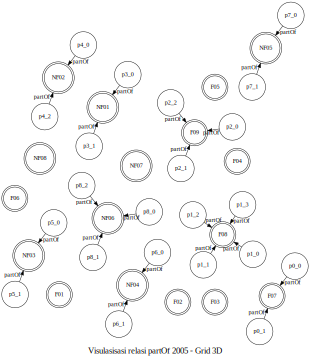

In [ ]:
partKu = partOf() # class partOf
a = partKu.fulldataset(srs_param) # menentukan kebutuhan
b = partKu.tabulasi_filter(a) # splitting sentence
c = partKu.tabulasi_pertama(b, a) # membuat tabulasi atomik dan non atomik
partKu.tabulasi_visual(c)

In [ ]:
# %%writefile evaluasi.py
#@title evaluasi { vertical-output: true }
data_param = "/content/drive/MyDrive/dataset/partOfAll/partOfGrd.xlsx" #@param {type:"string"}
mode_param = "describe" #@param ["main", "describe", "test", "grd"]

import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report
from tabulate import tabulate

class evaluasiData:
    def __init__(self, inputFile):
        self.data = inputFile

    def fulldataset(self, inputSRS): # function membuat dataset
        xl = pd.ExcelFile(self.data)
        dfs = {sh:xl.parse(sh) for sh in xl.sheet_names}[inputSRS]
        return dfs

    def preprocessing(self): # function melihat struktur dataset di excel
        xl = pd.ExcelFile(self.data)
        for sh in xl.sheet_names:
          df = xl.parse(sh)
          print('Processing: [{}] ...'.format(sh))
          print(df.head())

    def evaluation(self, data1, data2):
        hasil_evaluasi = []
        for idx, idy in zip(data1.drop('Dataset', axis= 1).values, data2.drop('Dataset', axis= 1).values):
            y_actual = idx.astype(int) #define array of actual values
            y_predicted = idy.astype(int) #define array of predicted values
            nilai_akurasi = accuracy_score(y_actual, y_predicted, normalize=True)
            nilai_recall = recall_score(y_actual, y_predicted, average= 'macro', zero_division= 1)
            nilai_presisi = precision_score(y_actual, y_predicted, average= 'macro', zero_division= 1)
            hasil_evaluasi.append([nilai_akurasi, nilai_recall, nilai_presisi])
        evaluasi_df = pd.DataFrame(hasil_evaluasi, columns= ['akurasi', 'recall', 'presisi'], index= test_df.Dataset)
        return evaluasi_df 

    def main(self, data1, data2, output= ['main', 'test', 'grd', 'describe']):
      if 'main' in output:
        eval = evaluasiData.evaluation(self, data1, data2).sort_values(by=['akurasi'], ascending= False).reset_index()
        print(tabulate(eval, headers = 'keys', tablefmt = 'psql'))
      elif 'describe' in output:
        eval = evaluasiData.evaluation(self, data1, data2).sort_values(by=['akurasi'], ascending= False).reset_index().describe()
        print(tabulate(eval, headers = 'keys', tablefmt = 'psql'))
      elif 'test' in output:
        print(tabulate(test_df, headers = 'keys', tablefmt = 'psql'))
      elif 'grd' in output:
        print(tabulate(grd_df, headers = 'keys', tablefmt = 'psql'))

if __name__ == "__main__":
  try:
    evalData = evaluasiData(data_param)
    test_df = evalData.fulldataset('test')
    grd_df = evalData.fulldataset('groundtruth')
    evalData.main(test_df, grd_df, mode_param)

# d = {
#     'akurasi': [0.8, 0.8, 1, 1, 1, 1, 0.4, 0.4, 1, 0.8, 0.8, 1], 
#      'recall': [0.833, 0.833, 1, 1, 1, 1,  0.625, 0.625, 1, 0.833, 0.833, 1],
#      'presisi': [0.833, 0.833, 1, 1, 1, 1,  0.625, 0.625, 1, 0.833, 0.833, 1]}
# df = pd.DataFrame(d, index= ['Grid-3D', 'colorcast', 'triangle', 'agentmom', 'philip', 
#                   'pugetSound', 'peering', 'gammaj', 'inventory', 'esa', 'spaceFraction', 'tachonet'])
# df.describe()

  except OSError as err:
    print("OS error: {0}".format(err))

+-------+-----------+-----------+-----------+
|       |   akurasi |    recall |   presisi |
|-------+-----------+-----------+-----------|
| count | 62        | 62        | 62        |
| mean  |  0.409677 |  0.615911 |  0.671032 |
| std   |  0.254603 |  0.162266 |  0.134472 |
| min   |  0.2      |  0.333333 |  0.5      |
| 25%   |  0.2      |  0.555556 |  0.564732 |
| 50%   |  0.4      |  0.571429 |  0.625    |
| 75%   |  0.4      |  0.625    |  0.714286 |
| max   |  1        |  1        |  1        |
+-------+-----------+-----------+-----------+


## Another Module

In [13]:
%%writefile stanfordSent.py
"""
Created on Th Oktober  7 18:07:24 2021
@author: Rakha asyrofi
stanford clause
"""

#@title Modul2a Stanford Clause { vertical-output: true }
url_param = "http://corenlp.run" #@param {type:"string"}
model_param = "/content/drive/MyDrive/stanford-corenlp-4.0.0" #@param {type:"string"}
dataFile = "/content/drive/MyDrive/dataset/dataset_2.xlsx" #@param {type:"string"}
srs_param = "2005 - Grid 3D" #@param ["0000 - cctns", "0000 - gamma j", "0000 - Inventory", "1998 - themas", "1999 - dii", "1999 - multi-mahjong", "1999 - tcs", "2000 - nasa x38", "2001 - ctc network", "2001 - esa", "2001 - hats", "2001 -libra", "2001 - npac", "2001 - space fractions", "2002 - evia back", "2002 - evia corr", "2003 - agentmom", "2003 - pnnl", "2003 - qheadache", "2003 - Tachonet", "2004 - colorcast", "2004 - eprocurement", "2004 - grid bgc", "2004 - ijis", "2004 - Phillip", "2004 - rlcs", "2004 - sprat", "2005 - clarus high", "2005 - clarus low", "2005 - Grid 3D", "2005 - nenios", "2005 - phin", "2005 - pontis", "2005 - triangle", "2005 - znix", "2006 - stewards", "2007 - ertms", "2007 - estore", "2007 - nde", "2007 - get real 0.2", "2007 - mdot", "2007 - nlm", "2007 - puget sound", "2007 - water use", "2008 - caiso", "2008 - keepass", "2008 - peering", "2008 - viper", "2008 - virtual ed", "2008 - vub", "2009 - email", "2009 - gaia", "2009 - inventory 2.0", "2009 - library", "2009 - library2", "2009 - peazip", "2009 - video search", "2009 - warc III", "2010 - blit draft", "2010 - fishing", "2010 - gparted", "2010 - home", "2010 - mashboot", "2010 - split merge"]
col_param = "Requirement Statement" #@param ["Requirement Statement", "req"]

import re, nltk, json, pandas as pd
# from pycorenlp import StanfordCoreNLP
from stanfordcorenlp import StanfordCoreNLP
from tabulate import tabulate

class stanford_clause:
    def __init__(self, fileName= dataFile, url_stanford= url_param, 
                 model_stanford = model_param):
        # self.nlp = StanfordCoreNLP(url_stanford)
        self.nlp = StanfordCoreNLP(url_stanford, port= 80)
        # self.nlp = StanfordCoreNLP(model_stanford)
        self.__data = fileName

    def fulldataset(self, inputSRS= col_param):
        xl = pd.ExcelFile(self.__data)
        dfs = {sh:xl.parse(sh) for sh in xl.sheet_names}[inputSRS]
        return dfs

    def preprocessing(self):
        xl = pd.ExcelFile(self.__data)
        for sh in xl.sheet_names:
          df = xl.parse(sh)
          print('Processing: [{}] ...'.format(sh))
          print(df.head())

    def get_verb_phrases(self, t):
        verb_phrases = []
        num_children = len(t)
        num_VP = sum(1 if t[i].label() == "VP" else 0 for i in range(0, num_children))

        if t.label() != "VP":
            for i in range(0, num_children):
                if t[i].height() > 2:
                    verb_phrases.extend(stanford_clause.get_verb_phrases(self, t[i]))
        elif t.label() == "VP" and num_VP > 1:
            for i in range(0, num_children):
                if t[i].label() == "VP":
                    if t[i].height() > 2:
                        verb_phrases.extend(stanford_clause.get_verb_phrases(self, t[i]))
        else:
            verb_phrases.append(' '.join(t.leaves()))

        return verb_phrases

    def get_pos(self, t):
        vp_pos = []
        sub_conj_pos = []
        num_children = len(t)
        children = [t[i].label() for i in range(0,num_children)]

        flag = re.search(r"(S|SBAR|SBARQ|SINV|SQ)", ' '.join(children))
        if "VP" in children and not flag:
            # print(t[i].label())
            for i in range(0, num_children):
                if t[i].label() == "VP":
                    vp_pos.append(t[i].treeposition())
        elif not "VP" in children and not flag:
            for i in range(0, num_children):
                if t[i].height() > 2:
                    temp1,temp2 = stanford_clause.get_pos(self, t[i])
                    vp_pos.extend(temp1)
                    sub_conj_pos.extend(temp2)
        else:
            for i in range(0, num_children):
                if t[i].label() in ["S","SBAR","SBARQ","SINV","SQ"]:
                    temp1, temp2 = stanford_clause.get_pos(self, t[i])
                    vp_pos.extend(temp1)
                    sub_conj_pos.extend(temp2)
                else:
                    sub_conj_pos.append(t[i].treeposition())

        return (vp_pos,sub_conj_pos)


    def get_clause_list(self, sent):
        parser = self.nlp.annotate(sent, properties={"annotators":"parse","outputFormat": "json"})
        # sent_tree = nltk.tree.ParentedTree.fromstring(parser["sentences"][0]["parse"])
        parser_json = json.loads(parser)
        sent_tree = nltk.tree.ParentedTree.fromstring(parser_json["sentences"][0]["parse"])
        clause_level_list = ["S","SBAR","SBARQ","SINV","SQ"]
        clause_list = []
        sub_trees = []

        # break the tree into subtrees of clauses using
        # clause levels "S","SBAR","SBARQ","SINV","SQ"
        for sub_tree in reversed(list(sent_tree.subtrees())):
            # print(sub_tree.label() == 'CC')
            if sub_tree.label() in clause_level_list:
                if sub_tree.parent().label() in clause_level_list:
                    continue
                if (len(sub_tree) == 1 and sub_tree.label() == "S" and sub_tree[0].label() == "VP"
                    and not sub_tree.parent().label() in clause_level_list):
                    continue
                sub_trees.append(sub_tree)
                del sent_tree[sub_tree.treeposition()]

        
        for t in sub_trees: # for each clause level subtree, extract relevant simple sentence
            verb_phrases = stanford_clause.get_verb_phrases(self, t) # get verb phrases from the new modified tree
            vp_pos,sub_conj_pos = stanford_clause.get_pos(self, t)
            for i in vp_pos:
                del t[i]
            for i in sub_conj_pos:
                del t[i]
            subject_phrase = ' '.join(t.leaves())
            for i in verb_phrases: # update the clause_list
                clause_list.append(subject_phrase + " " + i)
        return clause_list

    def __del__(self):
      print("descructed")

    def main(self):
        id_req = stanford_clause.fulldataset(self, srs_param)['ID']
        req = stanford_clause.fulldataset(self, srs_param)[col_param]

        data_clausa = []
        for id, num in zip(id_req, req):
            sent = re.sub(r"(\.|,|\?|\(|\)|\[|\])"," ",num)
            clause_list = [idx for idx in stanford_clause.get_clause_list(self, sent)]
            jml_clausa = len(clause_list)
            data_clausa.append([id, num, clause_list, jml_clausa])

        clausa_df = pd.DataFrame(data_clausa, columns= ['id', 'req', 'hasil', 'jml_clausa'])
        print(tabulate(clausa_df, headers = 'keys', tablefmt = 'psql'))
        stanford_clause.__del__(self)

if __name__ == "__main__":
  try:
    stanford_clause().main()
    # sent =  'Joe waited for the train, but the train was late.'
    # sent = re.sub(r"(\.|,|\?|\(|\)|\[|\])"," ",sent)
    # clause_list = stanford_clause().get_clause_list(sent)
    # print(clause_list)

  except OSError as err:
    print("OS error: {0}".format(err))

Overwriting stanfordSent.py


In [4]:
%%writefile clausySent.py
#@title spacy_sent { vertical-output: true }
spacy_param = "en_core_web_sm" #@param {type:"string"}
dataFile = "/content/drive/MyDrive/dataset/dataset_2.xlsx" #@param {type:"string"}
srs_param = "2005 - Grid 3D" #@param ["0000 - cctns", "0000 - gamma j", "0000 - Inventory", "1998 - themas", "1999 - dii", "1999 - multi-mahjong", "1999 - tcs", "2000 - nasa x38", "2001 - ctc network", "2001 - esa", "2001 - hats", "2001 -libra", "2001 - npac", "2001 - space fractions", "2002 - evia back", "2002 - evia corr", "2003 - agentmom", "2003 - pnnl", "2003 - qheadache", "2003 - Tachonet", "2004 - colorcast", "2004 - eprocurement", "2004 - grid bgc", "2004 - ijis", "2004 - Phillip", "2004 - rlcs", "2004 - sprat", "2005 - clarus high", "2005 - clarus low", "2005 - Grid 3D", "2005 - nenios", "2005 - phin", "2005 - pontis", "2005 - triangle", "2005 - znix", "2006 - stewards", "2007 - ertms", "2007 - estore", "2007 - nde", "2007 - get real 0.2", "2007 - mdot", "2007 - nlm", "2007 - puget sound", "2007 - water use", "2008 - caiso", "2008 - keepass", "2008 - peering", "2008 - viper", "2008 - virtual ed", "2008 - vub", "2009 - email", "2009 - gaia", "2009 - inventory 2.0", "2009 - library", "2009 - library2", "2009 - peazip", "2009 - video search", "2009 - warc III", "2010 - blit draft", "2010 - fishing", "2010 - gparted", "2010 - home", "2010 - mashboot", "2010 - split merge"]
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Th Oktober  7 18:07:24 2021
@author: Rakha asyrofi
spacy sent
"""

import spacy
import lemminflect
import logging
import typing

from spacy.tokens import Span, Doc
from spacy.matcher import Matcher
from lemminflect import getInflection

logging.basicConfig(level=logging.INFO)

# DO NOT SET MANUALLY
MOD_CONSERVATIVE = False

Doc.set_extension("clauses", default=[], force=True)
Span.set_extension("clauses", default=[], force=True)

dictionary = {
    "non_ext_copular": """die walk""".split(),
    "ext_copular": """act
appear
be
become
come
come out
end up
get
go
grow
fall
feel
keep
leave
look
prove
remain
seem
smell
sound
stay
taste
turn
turn up
wind up
live
come
go
stand
lie
love
do
try""".split(),
    "complex_transitive": """
bring
catch
drive
get
keep
lay
lead
place
put
set
sit
show
stand
slip
take""".split(),
    "adverbs_ignore": """so
then
thus
why
as
even""".split(),
    "adverbs_include": """
hardly
barely
scarcely
seldom
rarely""".split(),
}


class Clause:
    def __init__(
        self,
        subject: typing.Optional[Span] = None,
        verb: typing.Optional[Span] = None,
        indirect_object: typing.Optional[Span] = None,
        direct_object: typing.Optional[Span] = None,
        complement: typing.Optional[Span] = None,
        adverbials: typing.List[Span] = None,
    ):
        """


        Parameters
        ----------
        subject : Span
            Subject.
        verb : Span
            Verb.
        indirect_object : Span, optional
            Indirect object, The default is None.
        direct_object : Span, optional
            Direct object. The default is None.
        complement : Span, optional
            Complement. The default is None.
        adverbials : list, optional
            List of adverbials. The default is [].

        Returns
        -------
        None.

        """
        if adverbials is None:
            adverbials = []

        self.subject = subject
        self.verb = verb
        self.indirect_object = indirect_object
        self.direct_object = direct_object
        self.complement = complement
        self.adverbials = adverbials

        self.doc = self.subject.doc

        self.type = self._get_clause_type()

    def _get_clause_type(self):
        has_verb = self.verb is not None
        has_complement = self.complement is not None
        has_adverbial = len(self.adverbials) > 0
        has_ext_copular_verb = (
            has_verb and self.verb.root.lemma_ in dictionary["ext_copular"]
        )
        has_non_ext_copular_verb = (
            has_verb and self.verb.root.lemma_ in dictionary["non_ext_copular"]
        )
        conservative = MOD_CONSERVATIVE
        has_direct_object = self.direct_object is not None
        has_indirect_object = self.indirect_object is not None
        has_object = has_direct_object or has_indirect_object
        complex_transitive = (
            has_verb and self.verb.root.lemma_ in dictionary["complex_transitive"]
        )

        clause_type = "undefined"

        if not has_verb:
            clause_type = "SVC"
            return clause_type

        if has_object:
            if has_direct_object and has_indirect_object:
                clause_type = "SVOO"
            elif has_complement:
                clause_type = "SVOC"
            elif not has_adverbial or not has_direct_object:
                clause_type = "SVO"
            elif complex_transitive or conservative:
                clause_type = "SVOA"
            else:
                clause_type = "SVO"
        else:
            if has_complement:
                clause_type = "SVC"
            elif not has_adverbial or has_non_ext_copular_verb:
                clause_type = "SV"
            elif has_ext_copular_verb or conservative:
                clause_type = "SVA"
            else:
                clause_type = "SV"

        return clause_type

    def __repr__(self):
        return "<{}, {}, {}, {}, {}, {}, {}>".format(
            self.type,
            self.subject,
            self.verb,
            self.indirect_object,
            self.direct_object,
            self.complement,
            self.adverbials,
        )

    def to_propositions(
        self, as_text: bool = False, inflect: str or None = "VBD", capitalize: bool = False
    ):

        if inflect and not as_text:
            logging.warning("`inflect' argument is ignored when `as_text==False'. To suppress this warning call `to_propositions' with the argument `inflect=None'")
        if capitalize and not as_text:
            logging.warning("`capitalize' argument is ignored when `as_text==False'. To suppress this warning call `to_propositions' with the argument `capitalize=False")

        propositions = []

        subjects = extract_ccs_from_token_at_root(self.subject)
        direct_objects = extract_ccs_from_token_at_root(self.direct_object)
        indirect_objects = extract_ccs_from_token_at_root(self.indirect_object)
        complements = extract_ccs_from_token_at_root(self.complement)
        verbs = [self.verb] if self.verb else []

        for subj in subjects:
            if complements and not verbs:
                for c in complements:
                    propositions.append((subj, "is", c))
                propositions.append((subj, "is") + tuple(complements))

            for verb in verbs:
                prop = [subj, verb]
                if self.type in ["SV", "SVA"]:
                    if self.adverbials:
                        for a in self.adverbials:
                            propositions.append(tuple(prop + [a]))
                        propositions.append(tuple(prop + self.adverbials))
                    else:
                        propositions.append(tuple(prop))

                elif self.type == "SVOO":
                    for iobj in indirect_objects:
                        for dobj in direct_objects:
                            propositions.append((subj, verb, iobj, dobj))
                elif self.type == "SVO":
                    for obj in direct_objects + indirect_objects:
                        propositions.append((subj, verb, obj))
                        for a in self.adverbials:
                            propositions.append((subj, verb, obj, a))
                elif self.type == "SVOA":
                    for obj in direct_objects:
                        if self.adverbials:
                            for a in self.adverbials:
                                propositions.append(tuple(prop + [obj, a]))
                            propositions.append(tuple(prop + [obj] + self.adverbials))

                elif self.type == "SVOC":
                    for obj in indirect_objects + direct_objects:
                        if complements:
                            for c in complements:
                                propositions.append(tuple(prop + [obj, c]))
                            propositions.append(tuple(prop + [obj] + complements))
                elif self.type == "SVC":
                    if complements:
                        for c in complements:
                            propositions.append(tuple(prop + [c]))
                        propositions.append(tuple(prop + complements))

        # Remove doubles
        propositions = list(set(propositions))

        if as_text:
            return _convert_clauses_to_text(
                propositions, inflect=inflect, capitalize=capitalize
            )

        return propositions


def inflect_token(token, inflect):
    if (
        inflect
        and token.pos_ == "VERB"
        and "AUX" not in [tt.pos_ for tt in token.lefts]
        # t is not preceded by an auxiliary verb (e.g. `the birds were ailing`)
        and token.dep_ != "pcomp"
    ):  # t `dreamed of becoming a dancer`
        return str(token._.inflect(inflect))
    else:
        return str(token)


def _convert_clauses_to_text(propositions, inflect, capitalize):
    proposition_texts = []
    for proposition in propositions:
        span_texts = []
        for span in proposition:

            token_texts = []
            for token in span:
                token_texts.append(inflect_token(token, inflect))

            span_texts.append(" ".join(token_texts))
        proposition_texts.append(" ".join(span_texts))

    if capitalize:  # Capitalize and add a full stop.
        proposition_texts = [text.capitalize() + "." for text in proposition_texts]

    return proposition_texts


def _get_verb_matches(span):
    # 1. Find verb phrases in the span
    # (see mdmjsh answer here: https://stackoverflow.com/questions/47856247/extract-verb-phrases-using-spacy)

    verb_matcher = Matcher(span.vocab)
    verb_matcher.add(
        "Auxiliary verb phrase aux-verb", None, [{"POS": "AUX"}, {"POS": "VERB"}]
    )
    verb_matcher.add("Auxiliary verb phrase", None, [{"POS": "AUX"}])
    verb_matcher.add("Verb phrase", None, [{"POS": "VERB"}])

    return verb_matcher(span)


def _get_verb_chunks(span):
    matches = _get_verb_matches(span)

    # Filter matches (e.g. do not have both "has won" and "won" in verbs)
    verb_chunks = []
    for match in [span[start:end] for _, start, end in matches]:
        if match.root not in [vp.root for vp in verb_chunks]:
            verb_chunks.append(match)
    return verb_chunks


def _get_subject(verb):
    for c in verb.root.children:
        if c.dep_ in ["nsubj", "nsubjpass"]:
            subject = extract_span_from_entity(c)
            return subject

    root = verb.root
    while root.dep_ in ["conj", "cc", "advcl", "acl", "ccomp", "ROOT"]:
        for c in root.children:
            if c.dep_ in ["nsubj", "nsubjpass"]:
                subject = extract_span_from_entity(c)
                return subject

            if c.dep_ in ["acl", "advcl"]:
                subject = find_verb_subject(c)
                return extract_span_from_entity(subject) if subject else None

        # Break cycles
        if root == verb.root.head:
            break
        else:
            root = verb.root.head

    for c in root.children:
        if c.dep_ in ["nsubj", "nsubj:pass", "nsubjpass"]:
            subject = extract_span_from_entity(c)
            return subject
    return None


def _find_matching_child(root, allowed_types):
    for c in root.children:
        if c.dep_ in allowed_types:
            return extract_span_from_entity(c)
    return None


def extract_clauses(span):
    clauses = []

    verb_chunks = _get_verb_chunks(span)
    for verb in verb_chunks:

        subject = _get_subject(verb)
        if not subject:
            continue

        # Check if there are phrases of the form, "AE, a scientist of ..."
        # If so, add a new clause of the form:
        # <AE, is, a scientist>
        for c in subject.root.children:
            if c.dep_ == "appos":
                complement = extract_span_from_entity(c)
                clause = Clause(subject=subject, complement=complement)
                clauses.append(clause)

        indirect_object = _find_matching_child(verb.root, ["dative"])
        direct_object = _find_matching_child(verb.root, ["dobj"])
        complement = _find_matching_child(
            verb.root, ["ccomp", "acomp", "xcomp", "attr"]
        )
        adverbials = [
            extract_span_from_entity(c)
            for c in verb.root.children
            if c.dep_ in ("prep", "advmod", "agent")
        ]

        clause = Clause(
            subject=subject,
            verb=verb,
            indirect_object=indirect_object,
            direct_object=direct_object,
            complement=complement,
            adverbials=adverbials,
        )
        clauses.append(clause)
    return clauses


def extract_clauses_doc(doc):
    for sent in doc.sents:
        clauses = extract_clauses(sent)
        sent._.clauses = clauses
        doc._.clauses += clauses
    return doc


def add_to_pipe(nlp):
    nlp.add_pipe(extract_clauses_doc)


def extract_span_from_entity(token):
    ent_subtree = sorted([c for c in token.subtree], key=lambda x: x.i)
    return Span(token.doc, start=ent_subtree[0].i, end=ent_subtree[-1].i + 1)


def extract_span_from_entity_no_cc(token):
    ent_subtree = sorted(
        [token] + [c for c in token.children if c.dep_ not in ["cc", "conj", "prep"]],
        key=lambda x: x.i,
    )
    return Span(token.doc, start=ent_subtree[0].i, end=ent_subtree[-1].i + 1)


def extract_ccs_from_entity(token):
    entities = [extract_span_from_entity_no_cc(token)]
    for c in token.children:
        if c.dep_ in ["conj", "cc"]:
            entities += extract_ccs_from_entity(c)
    return entities


def extract_ccs_from_token_at_root(span):
    if span is None:
        return []
    else:
        return extract_ccs_from_token(span.root)


def extract_ccs_from_token(token):
    if token.pos_ in ["NOUN", "PROPN", "ADJ"]:
        children = sorted(
            [token]
            + [
                c
                for c in token.children
                if c.dep_ in ["advmod", "amod", "det", "poss", "compound"]
            ],
            key=lambda x: x.i,
        )
        entities = [Span(token.doc, start=children[0].i, end=children[-1].i + 1)]
    else:
        entities = [Span(token.doc, start=token.i, end=token.i + 1)]
    for c in token.children:
        if c.dep_ == "conj":
            entities += extract_ccs_from_token(c)
    return entities


def find_verb_subject(v):
    """
    Returns the nsubj, nsubjpass of the verb. If it does not exist and the root is a head,
    find the subject of that verb instead.
    """
    if v.dep_ in ["nsubj", "nsubjpass", "nsubj:pass"]:
        return v
    # guard against infinite recursion on root token
    elif v.dep_ in ["advcl", "acl"] and v.head.dep_ != "ROOT":
        return find_verb_subject(v.head)

    for c in v.children:
        if c.dep_ in ["nsubj", "nsubjpass", "nsubj:pass"]:
            return c
        elif c.dep_ in ["advcl", "acl"] and v.head.dep_ != "ROOT":
            return find_verb_subject(v.head)


if __name__ == "__main__":
    import spacy
    from spacySent import spacyClause
    nlp = spacy.load(spacy_param)
    add_to_pipe(nlp)
    data_c = []
    for id, num in zip(spacyClause(dataFile).fulldataset(srs_param)['ID'],
                       spacyClause(dataFile).fulldataset(srs_param)['Requirement Statement']):
        doc = nlp(num)
        sent_c = [clause.to_propositions(as_text=True, capitalize=True) for clause in doc._.clauses]
        jml_clausa = len(sent_c)
        data_c.append([id, num,  sent_c, jml_clausa])
    clausy_df = pd.DataFrame(data_c, columns = ['ID','req', 'clause', 'jml_klausa'])
    print(tabulate(clausy_df, headers = 'keys', tablefmt = 'psql'))


Overwriting clausySent.py


In [ ]:
%%writefile spacySent.py
"""
Created on Th Oktober  7 18:07:24 2021
@author: Rakha asyrofi
spacy parameter
"""

#@title Modul2b Spacy parameter { vertical-output: true }
spacy_param = 'en_core_web_sm' #@param {type:"string"}
dataFile = "/content/drive/MyDrive/dataset/dataset_2.xlsx" #@param {type:"string"}
srs_param = "2005 - Grid 3D" #@param ["0000 - cctns", "0000 - gamma j", "0000 - Inventory", "1998 - themas", "1999 - dii", "1999 - multi-mahjong", "1999 - tcs", "2000 - nasa x38", "2001 - ctc network", "2001 - esa", "2001 - hats", "2001 -libra", "2001 - npac", "2001 - space fractions", "2002 - evia back", "2002 - evia corr", "2003 - agentmom", "2003 - pnnl", "2003 - qheadache", "2003 - Tachonet", "2004 - colorcast", "2004 - eprocurement", "2004 - grid bgc", "2004 - ijis", "2004 - Phillip", "2004 - rlcs", "2004 - sprat", "2005 - clarus high", "2005 - clarus low", "2005 - Grid 3D", "2005 - nenios", "2005 - phin", "2005 - pontis", "2005 - triangle", "2005 - znix", "2006 - stewards", "2007 - ertms", "2007 - estore", "2007 - nde", "2007 - get real 0.2", "2007 - mdot", "2007 - nlm", "2007 - puget sound", "2007 - water use", "2008 - caiso", "2008 - keepass", "2008 - peering", "2008 - viper", "2008 - virtual ed", "2008 - vub", "2009 - email", "2009 - gaia", "2009 - inventory 2.0", "2009 - library", "2009 - library2", "2009 - peazip", "2009 - video search", "2009 - warc III", "2010 - blit draft", "2010 - fishing", "2010 - gparted", "2010 - home", "2010 - mashboot", "2010 - split merge"]

# dataFile = "/content/drive/MyDrive/dataset/visualPartOf/partOf2005 - Grid 3D.xlsx" #@param {type:"string"}
# srs_param = "tabel_partOf" #@param {type:"string"}
col_param = "Requirement Statement" #@param ["Requirement Statement", "req"]


import spacy
import pandas as pd
from tabulate import tabulate

class spacyClause:
  def __init__(self, fileName= dataFile):
      self.__data = fileName

  def fulldataset(self, inputSRS= col_param):
      xl = pd.ExcelFile(self.__data)
      dfs = {sh:xl.parse(sh) for sh in xl.sheet_names}[inputSRS]
      return dfs

  def preprocessing(self):
      xl = pd.ExcelFile(self.__data)
      for sh in xl.sheet_names:
        df = xl.parse(sh)
        print('Processing: [{}] ...'.format(sh))
        print(df.head())

  def find_root_of_sentence(self, doc):
      root_token = None
      for token in doc:
          if (token.dep_ == "ROOT"):
              root_token = token
      return root_token

  def find_other_verbs(self, doc, root_token):
      other_verbs = []
      for token in doc:
          ancestors = list(token.ancestors)
          if (token.pos_ == "VERB" and len(ancestors) == 1\
              and ancestors[0] == root_token):
              other_verbs.append(token)
      return other_verbs    

  def get_clause_token_span_for_verb(self, verb, doc, all_verbs):
      first_token_index = len(doc)
      last_token_index = 0
      this_verb_children = list(verb.children)
      for child in this_verb_children:
          if (child not in all_verbs):
              if (child.i < first_token_index):
                  first_token_index = child.i
              if (child.i > last_token_index):
                  last_token_index = child.i
      return first_token_index, last_token_index

  def extractData(self, doc):
      root_token = spacyClause.find_root_of_sentence(self, doc)
      other_verbs = spacyClause.find_other_verbs(self, doc, root_token)
      all_verbs = [root_token] + other_verbs
      token_spans = [spacyClause.get_clause_token_span_for_verb(self, other_verb, doc, all_verbs) for other_verb in all_verbs]   
      sentence_clauses = [doc[token_span[0]:token_span[1]] for token_span in token_spans if (token_span[0] < token_span[1])]
      sentence_clauses = sorted(sentence_clauses, key=lambda tup: tup[0])    
      clauses_text = [clause.text for clause in sentence_clauses]
      return clauses_text  

  def main(self):
      id_req = spacyClause.fulldataset(self, srs_param)['ID']
      req = spacyClause.fulldataset(self, srs_param)[col_param]
      dataSpacy = []
      nlp = spacy.load(spacy_param)
      for id, num in zip(id_req, req):
          doc = nlp(num)
          myClause = spacyClause.extractData(self, doc)
          jml_clausa = len(myClause)
          dataSpacy.append([id, num, myClause, jml_clausa])

      spacy_df = pd.DataFrame(dataSpacy, columns = ['ID', 'req', 'clause', 'jml_clausa'])
      print(tabulate(spacy_df, headers = 'keys', tablefmt = 'psql'))

if __name__ == "__main__":
  try:
    spacyClause().main()

  except OSError as err:
    print("OS error: {0}".format(err))

Writing spacySent.py


In [ ]:
#@title Build Subclause { vertical-output: true }
%%writefile subclause.py
import itertools
import networkx as nx


# !git clone https://github.com/Christopher-Thornton/subclause.git

def get_animate_words():
    animate_words = set(line.strip() for line in open('/content/subclause/animacy/animate.unigrams.txt', 'r', encoding='utf8'))
    animate_words.update({"i", "me", "myself", "mine", "my", "we", "us", "ourself", "ourselves", "ours", "our",
                          "you", "yourself", "yours", "your", "yourselves", "he", "him", "himself", "his", "she",
                          "her", "herself", "hers", "her", "one", "oneself", "one's", "they", "them", "themself",
                          "themselves", "theirs", "their", "they", "them", "'em", "themselves", "who", "whom",
                          "whose"})
    return animate_words


def get_inanimate_words():
    inanimate_words = set(line.strip() for line in open('/content/subclause/animacy/inanimate.unigrams.txt', 'r', encoding='utf8'))
    inanimate_words.update({"it", "itself", "its", "where", "when"})
    return inanimate_words


ANIMATE = get_animate_words()
INANIMATE = get_inanimate_words()


class SubClauseFinder:
    def __init__(self):
        # target relations of dependency parsing
        self.TARGET_RELATIONS = {'relcl', 'advcl', 'ccomp', 'csubj', 'csubjpass', 'xcomp'}

    def get_dependency_tree(self, root):
        # SpaCy dependency parse doesnt return a tree, start from the root token and
        # navigate down the tree via .children
        dependency_tree = [root]
        while sum([len(list(tok.children)) for tok in dependency_tree[-1]]) > 0:
            dependency_tree.append(list(itertools.chain.from_iterable(
                [list(tok.children) for tok in dependency_tree[-1]])))
        dependency_tree = list(itertools.chain.from_iterable(dependency_tree))
        return dependency_tree

    def get_subclauses(self, annotated_sent):
        root = [token for token in annotated_sent if token.dep_ == 'ROOT']
        dependency_tree = self.get_dependency_tree(root)

        # iterate the edges to find dependent clauses relations
        subordinate_edges = []
        for clause_root in dependency_tree:
            if clause_root.dep_ in self.TARGET_RELATIONS:
                subordinate_edges.append(clause_root)

        subclauses = []
        for clause_root in subordinate_edges:
            clause_type = self.identify_clause_type(clause_root.dep_)
            # extract information of specific clause type
            if clause_type == 'RELATIVE':
                clause = RelativeClause(annotated_sent, clause_root)
            elif clause_type == 'ADJUNCT':
                clause = AdjunctClause(annotated_sent, clause_root)
            elif clause_type == 'COMPLEMENT':
                clause = ComplementClause(annotated_sent, clause_root)
            else:
                raise ValueError
            subclauses.append(clause)
        return subclauses

    def identify_clause_type(self, clause_root_dep):
        if clause_root_dep == 'relcl':
            return 'RELATIVE'
        elif clause_root_dep == 'advcl':
            return 'ADJUNCT'
        elif clause_root_dep in {'ccomp', 'csubj', 'csubjpass', 'xcomp'}:
            return 'COMPLEMENT'
        else:
            raise ValueError


class SubordinateClause:
    # Abstract class for storing subordinate clause information.
    # Actual subordinate clauses extend this class.
    def __init__(self, annotated_sent, clause_root):
        self.annotated_sent = annotated_sent
        self.clause_root = clause_root
        self.clause_root_dep = clause_root.dep_
        # identify clause finiteness
        self.is_finite = None
        # type of subordinate clause
        self.clause_type = None
        self.clause_span = None
        # subordinator is'mark' in adverbial clauses and complement clause but 'ref' in relative clause
        self.subordinator = None
        # level of embeddedness, main clause at level 0
        self.embeddedness = None

    def get_is_finite(self):
        if self.is_finite is None:
            self.identify_finiteness()
        return self.is_finite

    def get_clause_type(self):
        if self.clause_type is None:
            self.identify_clause_type()
        return self.clause_type

    def get_clause_span(self):
        if self.clause_span is None:
            self.set_clause_span()
        return self.clause_span

    def get_subordinator(self):
        if self.subordinator is None:
            self.identify_subordinator()
        return self.subordinator

    def get_embeddedness(self):
        if self.embeddedness is None:
            self.count_embeddedness()
        return self.embeddedness

    def referent_dependency(self, outedge):
        """
        https://www.mathcs.emory.edu/~choi/doc/cu-2012-choi.pdf
        A referent is the relation between a wh-complementizer in a relative clause and its referential head. In
        Referent relations are represented as secondary dependencies because integrating them with
        other dependencies breaks the single-head tree property (e.g., which would have multiple heads in Figure 28).
        """
        # TODO: Not Implemented
        return False

    def identify_subordinator(self):
        # for relative clauses, find the "referent"
        if self.get_clause_type() == 'RELATIVE':
            head_noun = self.clause_root.head
            for child in head_noun.children:
                if self.referent_dependency(child):
                    self.subordinator = child
        else:
            # for adverbial and complement clauses, find the "mark"
            for child in self.clause_root.children:
                child_dep = child.dep_
                if child_dep == 'mark':  # MARKER
                    self.subordinator = child

    def set_clause_span(self):
        self.clause_span = self.make_span(self.clause_root)

    def count_embeddedness(self):
        sent_root = [token for token in self.annotated_sent if token.dep_ == 'ROOT'][0]
        if sent_root.head.i == sent_root.i or sent_root.i == self.clause_root.i:
            self.embeddedness = 1
            return
        # find number of edges to go from clause root to sent root
        # Load spaCy's dependency tree into a networkx graph
        edges = []
        for token in self.annotated_sent:
            for child in token.children:
                edges.append(('{0}'.format(token.i),
                              '{0}'.format(child.i)))
        graph = nx.Graph(edges)
        # Get the length and path
        levels = nx.shortest_path_length(graph, source=str(self.clause_root.i), target=str(sent_root.i))
        return levels

    def identify_clause_type(self):
        if self.clause_root_dep == 'relcl':
            self.clause_type = 'RELATIVE'
        elif self.clause_root_dep == 'advcl':
            self.clause_type = 'ADJUNCT'
        elif self.clause_root_dep in {'ccomp', 'csubj', 'csubjpass', 'xcomp'}:
            self.clause_type = 'COMPLEMENT'

    def identify_finiteness(self):
        """
        check if the sub clause finite
        Finite clauses are clauses that contain verbs which show tense. Otherwise they are nonfinite.
        some examples:
        I had something to eat [before leaving].
        [After having spent six hours at the hospital], they eventually came home.
        [Helped by local volunteers], staff at the museum have spent many years cataloguing photographs.
        He left the party and went home, [not having anyone to talk to].
        The person to ask [about going to New Zealand] is Beck.
        You have to look at the picture really carefully [in order to see all the detail].
        """
        # xcomp is nonfinite by definition
        if self.clause_root_dep == 'xcomp':
            self.is_finite = False
            return
        # the verb is the root of the clause
        idx_word_before_verb = self.clause_root.i - 1
        verb_pos = self.clause_root.pos_
        if idx_word_before_verb < self.annotated_sent.start:
            if verb_pos in {"VBG"  "VBN"}:
                self.is_finite = False
                return
            else:
                # not VBG or VBN, then finite
                self.is_finite = True
                return
        wordBeforeVerb = self.annotated_sent[idx_word_before_verb - self.annotated_sent.start]
        #  if the verb follows TO or a preposition, it is nonfinite
        posWordBeforeVerb = wordBeforeVerb.pos_
        if posWordBeforeVerb in {"IN", "TO"}:
            self.is_finite = False
            return
        # if verb is gerund (VBG), it must have an aux, otherwise nonfinite
        if verb_pos == "VBG":
            hasAux = False
            # check if there is aux
            for child in self.clause_root.children_:  # childIterable(self.clause_root)
                rel = child.dep_
                if rel == "aux":
                    hasAux = True
            if not hasAux:
                self.is_finite = False
                return
        # if verb is past participle (VBN), it must have aux/auxpass which is not VBGs, otherwise non-finite
        if verb_pos == "VBN":
            vbg_aux = False
            # check if there is aux that is not in gerund form
            for child in self.clause_root.children_:  # childIterable
                if child.dep_ in {"aux" "auxpass"}:
                    # get pos of aux
                    aux = child  # child.getDependent()
                    auxPOS = aux.pos_
                    if auxPOS == "VBG":
                        vbg_aux = True
                    if vbg_aux:
                        self.is_finite = False
                        return
        self.is_finite = True

    def make_span(self, word):
        i = word.i - self.annotated_sent.start
        span = self.annotated_sent[
               self.annotated_sent[i].left_edge.i - self.annotated_sent.start:
               self.annotated_sent[i].right_edge.i + 1 - self.annotated_sent.start]

        return span


class RelativeClause(SubordinateClause):
    def __init__(self, annotated_sent, clause_root):
        super().__init__(annotated_sent, clause_root)
        self.clause_type = "RELATIVE"
        # further information related to relative clause
        self.is_restrictive = None
        # head noun
        # TODO: Decide if noun chunking should be used
        self.head_noun = self.clause_root.head
        self.is_head_noun_animate = None
        # head noun role in main clause
        self.head_noun_role_in_main_clause = None
        self.head_noun_role_in_sub_clause = None
        # relative clauses's embeddedness is different from the other two types of clause
        self.embeddedness = max(self.get_embeddedness() - 1, 1)

    def get_head_noun(self):
        return self.head_noun

    def get_head_noun_animacy(self):
        if self.get_head_noun() is not None:
            if self.is_head_noun_animate is None:
                self.set_head_noun_animacy()
            return self.is_head_noun_animate

    def get_head_noun_role_in_main_clause(self):
        if self.get_head_noun() is not None:
            if self.head_noun_role_in_main_clause is None:
                self.set_head_noun_roles()
            return self.head_noun_role_in_main_clause

    def get_head_noun_role_in_sub_clause(self):
        if self.get_head_noun() is not None:
            if self.head_noun_role_in_sub_clause is None:
                self.set_head_noun_roles()
            return self.head_noun_role_in_sub_clause

    def get_is_restrictive(self):
        if self.is_restrictive is None:
            self.set_restrictiveness()
        return self.is_restrictive

    def set_head_noun_animacy(self):
        # TODO: use alternate method to detect animacy (Language Models)
        if self.get_head_noun() in ANIMATE:
            self.is_head_noun_animate = True
        else:
            self.is_head_noun_animate = False

    def set_head_noun_roles(self):
        # TODO: Check function
        # https://www.brighthubeducation.com/english-homework-help/32754-the-functions-of-nouns-and-noun-phrases/
        is_from_inside_rc = False
        edge = self.get_head_noun()
        relation = edge.dep_
        head_idx = edge.head.i

        # see if it is from inside or outside of the RC
        span = self.get_clause_span()
        if span.start <= head_idx <= span.end-1:
            is_from_inside_rc = True

        if relation in {'nsubj', 'nsubjpass'}:
            self.set_role('SUBJECT', is_from_inside_rc)
        elif relation == 'dobj':
            self.set_role('DIRECT_OBJECT', is_from_inside_rc)
        elif relation == 'pobj':  # 'iobj'
            self.set_role('INDIRECT_OBJECT', is_from_inside_rc)
        elif relation == 'nmod':
            self.set_role('PREPOSITION_COMPLEMENT', is_from_inside_rc)
        elif relation == 'appos':
            self.set_role('APPOSITIVE', is_from_inside_rc)

    def set_role(self, role, is_from_inside_rc):
        if is_from_inside_rc:
            self.head_noun_role_in_sub_clause = role
        else:
            self.head_noun_role_in_main_clause = role

    def set_restrictiveness(self):
        # if zero relativizer or "that", restrictive
        subordinator = self.get_subordinator()
        if subordinator is None or subordinator.text.lower() == "that":
            self.is_restrictive = True
            return

        head_noun = self.get_head_noun()
        if head_noun is not None:
            # if the head noun is personal pronoun or proper noun(s), the clause is nonrestrictive
            head_noun_pos = head_noun.pos_
            if head_noun_pos in {"NNP", "NNPS", "PRP"}:
                self.is_restrictive = False
                return
            # if the head noun is modified by an indefinite determiner like 'a', 'some', or 'any', restrictive
            for child in head_noun.children:
                relation = child.dep_
                if relation == 'det':  # DETERMINER
                    determiner = child.text.lower()
                    if determiner in {"a", "an", "some", "any"}:
                        self.is_restrictive = True
                        return
        self.is_restrictive = True


class AdjunctClause(SubordinateClause):
    # function of clause, e.g. temporal, modal, instrumental...
    def __init__(self, annotated_sent, clause_root):
        super().__init__(annotated_sent, clause_root)

        self.clause_type = "ADJUNCT"

        self.TIME_SUBORDINATORS = {"when", "before", "after", "since", "while", "as", "till", "until"}
        self.PLACE_SUBORDINATORS = {"where", "wherever", "anywhere", "everywhere"}
        self.CONDITION_SUBORDINATORS = {"if", "unless", "lest", "provided"}
        self.REASON_SUBORDINATORS = {"because", "since", "as", "given"}
        self.CONCESSION_SUBORDINATORS = {"although", "though"}
        self.PURPOSE_SUBORDINATORS = {"so", "to"}
        self.COMPARISON_SUBORDINATORS = {"than"}
        self.MANNER_SUBORDINATORS = {"like", "way"}
        self.RESULTS_SUBORDINATORS = {"so", "such"}

        self.adjunct_function = None

    def get_adjunct_function(self):
        if self.adjunct_function is None:
            self.assign_function()
        return self.adjunct_function

    def assign_function(self):
        subordinator = self.get_subordinator()
        if subordinator is None:
            self.adjunct_function = None
            return
        subordinator = subordinator.text.lower()
        if subordinator in self.TIME_SUBORDINATORS:
            self.adjunct_function = 'TIME'
        elif subordinator in self.PLACE_SUBORDINATORS:
            self.adjunct_function = 'PLACE'
        elif subordinator in self.CONDITION_SUBORDINATORS:
            self.adjunct_function = 'CONDITION'
        elif subordinator in self.REASON_SUBORDINATORS:
            self.adjunct_function = 'REASON'
        elif subordinator in self.CONCESSION_SUBORDINATORS:
            self.adjunct_function = 'CONCESSION'
        elif subordinator in self.PURPOSE_SUBORDINATORS:
            self.adjunct_function = 'PURPOSE'
        elif subordinator in self.COMPARISON_SUBORDINATORS:
            self.adjunct_function = 'COMPARISION'
        elif subordinator in self.MANNER_SUBORDINATORS:
            self.adjunct_function = 'MANNER'
        elif subordinator in self.RESULTS_SUBORDINATORS:
            self.adjunct_function = 'RESULTS'
        else:
            self.adjunct_function = 'OTHER'


class ComplementClause(SubordinateClause):
    def __init__(self, annotated_sent, clause_root):
        super().__init__(annotated_sent, clause_root)

        self.clause_type = "COMPLEMENT"
        # set complement type (subject or object)
        self.complement_type = None

    def get_complement_type(self):
        if self.complement_type is None:
            self.identify_complement_type()
        return self.complement_type

    def identify_complement_type(self):
        # ccomp is always object complement by definition
        if self.clause_root.dep_ == "ccomp":
            self.complement_type = 'OBJECT_COMPLEMENT'
            return
        # check governor/head of edge.
        # If it is outside the clause, it is an object complement, otherwise subject,
        # because English is an SVO language
        head_idx = self.clause_root.head.i

        span = self.get_clause_span()
        if span.start <= head_idx <= span.end-1:
            self.complement_type = 'OBJECT_COMPLEMENT'
        else:
            self.complement_type = 'SUBJECT_COMPLEMENT'


if __name__ == '__main__':
    import spacy
    nlp = spacy.load('en_core_web_sm')

    subclausefinder = SubClauseFinder()

    text = "The door opened because the man pushed it. " \
           "I wondered whether the homework was necessary. " \
           "They will visit you before they go to the airport. " \
           "Before they go to the airport, they will visit you. " \
           "I went to the show that was very popular."

    doc = nlp(text)

    for sent in doc.sents:
        print('\nSentence:', sent)
        subclauses = subclausefinder.get_subclauses(sent)
        for sc in subclauses:
            print("\tclause text:", sc.get_clause_span())
            print("\tis finite:", sc.get_is_finite())
            print("\tsubordinator:", sc.get_subordinator())
            print("\tembeddedness:", sc.get_embeddedness())
            print("\tclause type:", sc.get_clause_type())
            # for complement clauses
            if sc.get_clause_type() == 'COMPLEMENT':
                print("\t\tcomplement type:", sc.get_complement_type())
            # for adverbial clauses
            elif sc.get_clause_type() == 'ADJUNCT':
                print("\t\tadjunct function:", sc.get_adjunct_function())
            # for relative clauses
            elif sc.get_clause_type() == 'RELATIVE':
                print("\t\tis restrictive:", sc.get_is_restrictive())
                print("\t\thead noun:", sc.get_head_noun())
                print("\t\tis head noun animate:", sc.get_head_noun_animacy())
                print("\t\thead noun role in main clause:", sc.get_head_noun_role_in_main_clause())
                print("\t\thead noun role in subordinate clause:", sc.get_head_noun_role_in_sub_clause())

Writing subclause.py


In [ ]:
%%writefile triplet.py
"""
Created on Th Oktober  7 18:07:24 2021
@author: Rakha asyrofi
triplet parameter
"""

#@title Modul2c: Triplet NLTK-Stanford Triplet Parameter { vertical-output: true }
url_param = "http://corenlp.run/" #@param {type:"string"}
dataFile = "/content/drive/MyDrive/dataset/dataset_2.xlsx" #@param {type:"string"}
srs_param = "2003 - Tachonet" #@param ["0000 - cctns", "0000 - gamma j", "0000 - Inventory", "1998 - themas", "1999 - dii", "1999 - multi-mahjong", "1999 - tcs", "2000 - nasa x38", "2001 - ctc network", "2001 - esa", "2001 - hats", "2001 -libra", "2001 - npac", "2001 - space fractions", "2002 - evia back", "2002 - evia corr", "2003 - agentmom", "2003 - pnnl", "2003 - qheadache", "2003 - Tachonet", "2004 - colorcast", "2004 - eprocurement", "2004 - grid bgc", "2004 - ijis", "2004 - Phillip", "2004 - rlcs", "2004 - sprat", "2005 - clarus high", "2005 - clarus low", "2005 - Grid 3D", "2005 - nenios", "2005 - phin", "2005 - pontis", "2005 - triangle", "2005 - znix", "2006 - stewards", "2007 - ertms", "2007 - estore", "2007 - nde", "2007 - get real 0.2", "2007 - mdot", "2007 - nlm", "2007 - puget sound", "2007 - water use", "2008 - caiso", "2008 - keepass", "2008 - peering", "2008 - viper", "2008 - virtual ed", "2008 - vub", "2009 - email", "2009 - gaia", "2009 - inventory 2.0", "2009 - library", "2009 - library2", "2009 - peazip", "2009 - video search", "2009 - warc III", "2010 - blit draft", "2010 - fishing", "2010 - gparted", "2010 - home", "2010 - mashboot", "2010 - split merge"]

# dataFile = "/content/drive/MyDrive/dataset/visualPartOf/partOf2005 - Grid 3D.xlsx" #@param {type:"string"}
# srs_param = "tabel_partOf" #@param {type:"string"}

col_param = "Requirement Statement" #@param ["Requirement Statement", "req"]
mode_param = "result" #@param ["parse_tree", "spo", "result"]

import nltk, pandas as pd, numpy as np
from nltk.tag.stanford import CoreNLPPOSTagger
from nltk.tree import ParentedTree
from tabulate import tabulate

class extractNlp:
  def __init__(self, coreUrl = url_param, fileName= dataFile):
      self.__pos_tagger = CoreNLPPOSTagger(url= coreUrl)
      self.__data = fileName

  def fulldataset(self, inputSRS= 'req'):
      xl = pd.ExcelFile(self.__data)
      dfs = {sh:xl.parse(sh) for sh in xl.sheet_names}[inputSRS]
      return dfs

  def preprocessing(self):
      xl = pd.ExcelFile(self.__data)
      for sh in xl.sheet_names:
        df = xl.parse(sh)
        print('Processing: [{}] ...'.format(sh))
        print(df.head())

  def triplet_extraction (self, input_sent, output=['parse_tree','spo','result']):
      parse_tree, = ParentedTree.convert(list(self.__pos_tagger.parse(input_sent.split()))[0])

      # Extract subject, predicate and object
      subject = extractNlp.extract_subject(self, parse_tree)
      predicate = extractNlp.extract_predicate(self, parse_tree)
      objects = extractNlp.extract_object(self, parse_tree)
      if 'parse_tree' in output:
          print('---Parse Tree---')
          parse_tree.pretty_print()
      elif 'spo' in output:
          return ("subject:\t{}\npredicate:\t{}\nobject:\t{}".format(subject, predicate, objects))
      elif 'result' in output:
          return (' '.join([subject[0], predicate[0], objects[0]]))

  def extract_subject (self, parse_tree):
      # Extract the first noun found in NP_subtree
      subject = []
      for s in parse_tree.subtrees(lambda x: x.label() == 'NP'):
          for t in s.subtrees(lambda y: y.label().startswith('NN')):
              output = [t[0], extractNlp.extract_attr(self, t)]
              # Avoid empty or repeated values
              if output != [] and output not in subject:
                  subject.append(output) 
      if len(subject) != 0: return subject[0] 
      else: return ['']

  def extract_predicate (self, parse_tree):
      # Extract the deepest(last) verb foybd ub VP_subtree
      output, predicate = [],[]
      for s in parse_tree.subtrees(lambda x: x.label() == 'VP'):
          for t in s.subtrees(lambda y: y.label().startswith('VB')):
              output = [t[0], extractNlp.extract_attr(self, t)]
              if output != [] and output not in predicate:    
                  predicate.append(output)
      if len(predicate) != 0: return predicate[-1]
      else: return ['']

  def extract_object (self, parse_tree):
      # Extract the first noun or first adjective in NP, PP, ADP siblings of VP_subtree
      objects, output, word = [],[],[]
      for s in parse_tree.subtrees(lambda x: x.label() == 'VP'):
          for t in s.subtrees(lambda y: y.label() in ['NP','PP','ADP']):
              if t.label() in ['NP','PP']:
                  for u in t.subtrees(lambda z: z.label().startswith('NN')):
                      word = u          
              else:
                  for u in t.subtrees(lambda z: z.label().startswith('JJ')):
                      word = u
              if len(word) != 0:
                  output = [word[0], extractNlp.extract_attr(self, word)]
              if output != [] and output not in objects:
                  objects.append(output)
      if len(objects) != 0: return objects[0]
      else: return ['']

  def extract_attr (self, word):
      attrs = []     
      # Search among the word's siblings
      if word.label().startswith('JJ'):
          for p in word.parent(): 
              if p.label() == 'RB':
                  attrs.append(p[0])
      elif word.label().startswith('NN'):
          for p in word.parent():
              if p.label() in ['DT','PRP$','POS','JJ','CD','ADJP','QP','NP']:
                  attrs.append(p[0])
      elif word.label().startswith('VB'):
          for p in word.parent():
              if p.label() == 'ADVP':
                  attrs.append(p[0])
      # Search among the word's uncles
      if word.label().startswith('NN') or word.label().startswith('JJ'):
          for p in word.parent().parent():
              if p.label() == 'PP' and p != word.parent():
                  attrs.append(' '.join(p.flatten()))
      elif word.label().startswith('VB'):
          for p in word.parent().parent():
              if p.label().startswith('VB') and p != word.parent():
                  attrs.append(' '.join(p.flatten()))
      return attrs
  
  def __del__(self):
      print("destructed")

  def main(self, output):
      id_req = extractNlp.fulldataset(self, srs_param)['ID']
      data_num = [num for num in extractNlp.fulldataset(self, srs_param)[col_param]]
      data_triplet = [extractNlp.triplet_extraction(self, num, output= mode_param) 
                      for num in extractNlp.fulldataset(self, srs_param)[col_param]]
      triplet_df = pd.DataFrame([data_num, data_triplet], index= ['origin', 'triplet'], columns= id_req).T
      print(tabulate(triplet_df, headers = 'keys', tablefmt = 'psql'))
      extractNlp.__del__(self)

if __name__ == "__main__":
  try:
    extractNlp().main(mode_param)

  except OSError as err:
    print("OS error: {0}".format(err))

Writing triplet.py


## Reference

In [ ]:
import nltk
from nltk.tag.stanford import CoreNLPPOSTagger

part1 = partOf() 
dataReq = part1.fulldataset(srs_param)
pos_tagger = CoreNLPPOSTagger(url= "http://corenlp.run")
a = dataReq['Requirement Statement'][7]
sents = nltk.sent_tokenize(a)
parse_tree, = ParentedTree.convert(list(pos_tagger.parse(a.split()))[0])
tokens = [nltk.word_tokenize(num) for num in sents]
tag = [pos_tagger.tag(num) for num in tokens]
c = pos_tagger.parse(sents)
parse_tree, = ParentedTree.convert(list(c))

# tab1 = pd.DataFrame([a, sents], index= ['F08', 'K1']).T
# print(tabulate(tab1, headers = 'keys', tablefmt = 'psql'))
# tab2 = pd.DataFrame([sents, tokens], index= ['K1', 'tokenized_K1']).T
# print(tabulate(tab2, headers = 'keys', tablefmt = 'psql'))
# tab3 = pd.DataFrame([tokens, tag], index= ['tokenized_K1', 'Tagged_K1']).T
# print(tabulate(tab3, headers = 'keys', tablefmt = 'psql'))
# tab4 = pd.DataFrame([tag, parse_tree], index= ['Tagged_K1', 'Parse_K1']).T
# print(tabulate(tab4, headers = 'keys', tablefmt = 'psql'))

tab1 = pd.DataFrame([a, sents, tokens, tag, parse_tree], index = ['F07', 'K1', 'tokenized_K1', 'Tagged_K1', 'Parse_K1'])
print(tabulate(tab1, headers = 'keys', tablefmt = 'psql'))

# num = 'The product should allow the grid to be oriented by the user.' 
# num1 = 'Rotation functions should be employed'
# num2 = 'zoom functions should be employed'
# num3 = 'move functions should be employed'
# sents = nltk.sent_tokenize(num)
# tokens = [nltk.word_tokenize(num) for num in sents]
# tag = [pos_tagger.tag(num) for num in tokens]
# parse_tree, = ParentedTree.convert(list(pos_tagger.parse(num3.split()))[0])
# print(parse_tree)

# part3 = partOf(inputData= '/content/drive/MyDrive/dataset/dataset_2_grd.xlsx') 
# dataGrd = part3.fulldataset('stat')
# dataTest = part3.fulldataset('test')
# for idx, num in enumerate(dataGrd.Dataset):
#   y_actual = dataTest.drop('Dataset', axis= 1).fillna(0).iloc[idx].values.astype(int) #define array of actual values
#   y_predicted = dataGrd.drop('Dataset', axis= 1).iloc[idx].values.astype(int) #define array of predicted values
#   nilai_akurasi = accuracy_score(y_true= y_actual, y_pred= y_predicted, normalize=True, sample_weight=None)
#   nilai_recall = recall_score(y_true= y_actual, y_pred= y_predicted, average= 'macro')
#   nilai_presisi = precision_score(y_true= y_actual, y_pred= y_predicted, average= 'macro')
#   print("Data_{}\nakurasi {}\n recall {}\n presisi {}\n".format(num, nilai_akurasi, nilai_recall, nilai_presisi))
#   print(classification_report(y_true= y_actual, y_pred= y_predicted))

Destructed_called
+--------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|              | 0                                                                                                                                                                                                                                                                                                                                                                            |
|--------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------